### Data Model for the LILA dataset
The dataset is available on the [site](http://lila.science/datasets)

The bounding box list given in the dataset has the encodings in the form  [x, y, width, height] which is:
- x: xmin
- y: ymin

The standard values needed for tensorflow api can be derived as:
- xmin: x
- ymin: y
- xmax: x+width
- ymax: y+height

Here, we are trying to create a TFRecord file that can be fed into the object deection API

In [17]:
# importing libraries needed to process the lila dataset
import os, sys, csv, io
import json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

from sklearn.model_selection import train_test_split # for splitting the data into train and eval

sys.path.append('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/')
from utils import dataset_util
#Added this to handle the truncation error while decoding the jpeg
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
"""read the json file from the LILA: Snapshot Serengeti into a dictionary
The dictionary keys are:
annotations: this the bounding box level annotations
images: Information of the image
info: dataset creator information
categories: has a mapping similar to the label map

"""
with open('../data/LILA/SnapshotSerengeti.json', 'r') as f:
    dict1 = json.load(f)
    
# read the bounding box annotations and the image information to dataframes
df_annotations = pd.DataFrame(dict1['annotations'])
# Removing the unknown category from the dataset
df_annotations = df_annotations.loc[df_annotations['category_id']!=1000]
print(df_annotations.shape)
df_images = pd.DataFrame(dict1['images'])
print(df_images.shape)
df_categories = pd.DataFrame(dict1['categories'])
print(df_categories.shape)
# df_images['image_id'] = df_images['file_name'][:-4]

(3241246, 3)
(3198737, 10)
(49, 2)


**Checking the contents of the json file**

In [3]:
df_annotations.head(n = 2)

,category_id,id,image_id
0,1,94cdea27-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0001
1,1,94cdea29-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0002


In [4]:
df_images.head(n = 2)

,datetime,file_name,frame_num,height,id,location,season,seq_id,seq_num_frames,width
0,2010-07-18 16:26:14,S1/B04/B04_R1/S1_B04_R1_PICT0001.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0001,B04,S1,ASG0002kjh,1,2048
1,2010-07-18 16:26:30,S1/B04/B04_R1/S1_B04_R1_PICT0002.JPG,0,1536,S1/B04/B04_R1/S1_B04_R1_PICT0002,B04,S1,ASG0002kji,1,2048


In [5]:
df_categories.head(n = 2)

,id,name
0,0,empty
1,1,human


**1. Excluding the events that are present in Schneider's data**: This is because Schneider's data is our test data and needs to be of elements that are not seen by the model while training.<br>
**2. Excluding the events that are in the training bounding box dataset.**

In [6]:
# 1. 
df_schneider_box = pd.read_csv('/home/ubuntu/data/tensorflow/my_workspace/training_demo/Data/GoldStandardBoundBoxCoord.csv')
schneider_events = list(set(df_schneider_box['filename']))
schneider_events = [word.split('.')[0] for word in schneider_events] # [word[:-4] for word in schneider_events]
len(schneider_events)

4011

In [7]:
# 2.
l = []
with open("../data/LILA/msi_image_names.csv",'r') as f:
    rd = csv.reader(f)
    for val in rd:
        l.append(val)
        
l = l[0]

In [8]:
l[0]

'S5/J02/J02_R1/S5_J02_R1_IMAG0829'

In [9]:
schneider_events[0]

'ASG000ekoa'

**Creating the dictionary object that can feed into the function create_tf_example to generate TFRecord object**

In [10]:
"""The function create_tf_example takes in a dictionary as input. 
And so we need to preprocess the LILA dataset into the required format.
This dictionary has the following keys values:
{CaptureEventID: {'metadata' : {"SiteID": val,
                                "DateTime": val, 
                                "Season": val
                                },
                                'images' : [{"Path" : val), #points to the route of image on the disk
                                "URL" : val,
                                "dim_x" : val,
                                "dim_y" : val,
                                "image_label" : "tbd"} # This is the image level label if any
                               ]}
                                
"""

# Join the tables df_annotations and df_images
df_bb_meta = pd.merge(left=df_annotations, 
                      right=df_images, 
                      how='left',
                      left_on=df_annotations['image_id'], 
                      right_on=df_images['id'])
df_bb_meta = df_bb_meta.drop(columns=['key_0', 'id_y'])

df_bb_meta = pd.merge(left=df_bb_meta, 
                      right=df_categories, 
                      how='left',
                      left_on=df_bb_meta['category_id'], 
                      right_on=df_categories['id'])
df_bb_meta = df_bb_meta.drop(columns=['key_0', 'id'])
print("Shape before removing overlapping images with schneider's data: ", df_bb_meta.shape)

# Removing the overlapping images with Schneider's data
df_bb_meta = df_bb_meta[~df_bb_meta['seq_id'].isin(schneider_events)]
print("Shape after removing overlapping images with schneider's data: ", df_bb_meta.shape)

# 1.
# Removing the event that have been used for training the model
event_in_training = list(df_bb_meta[df_bb_meta['image_id'].isin(l)]['seq_id'])
df_bb_meta = df_bb_meta[~df_bb_meta['seq_id'].isin(event_in_training)]
print("Shape after removing images used for training the model: ", df_bb_meta.shape)

# 2.
# Removing humans from the data
df_bb_meta = df_bb_meta.loc[~df_bb_meta['category_id'].isin([0, 1])]
print("Shape after removing human and empty images: ", df_bb_meta.shape)
# Converting the dataframe to th dictionary for convenience
dict_bb_meta = df_bb_meta.to_dict('records')

Shape before removing overlapping images with schneider's data:  (3241246, 13)
Shape after removing overlapping images with schneider's data:  (3229976, 13)
Shape after removing images used for training the model:  (3190843, 13)
Shape after removing human and empty images:  (815026, 13)


In [11]:
print('Dataframe size of the df_bb_meta is: {0}'.format(df_bb_meta.shape))
df_bb_meta.head(n=2)

Dataframe size of the df_bb_meta is: (815026, 13)


,category_id,id_x,image_id,datetime,file_name,frame_num,height,location,season,seq_id,seq_num_frames,width,name
8,5,94cdea37-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0009,2010-07-30 05:20:22,S1/B04/B04_R1/S1_B04_R1_PICT0009.JPG,0,1536,B04,S1,ASG0002kjp,1,2048,zebra
11,5,94cdea3d-ad6d-11e8-88e9-000d3a062ba9,S1/B04/B04_R1/S1_B04_R1_PICT0012,2010-07-30 20:57:28,S1/B04/B04_R1/S1_B04_R1_PICT0012.JPG,0,1536,B04,S1,ASG0002kjs,1,2048,zebra


##### Saving the list of images to be used for inference.
- These images used for inference/prediction will be the ones other than images used for training, evaluation and testing the model.
    - Encode the images into TFRecord on the MSI using "python msi_image_TFRecord_encoding.py"
    - Use sftp to get the TFRecord to the local "/Desktop/UMN"
    - Use sftp to move the TFRecord to AWS "/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/ss_all/"

In [17]:
msi_snapshot_serengeti = list(df_bb_meta['image_id'])

with open("../data/LILA/msi_snapshot_serengeti.csv",'w') as f:
    wr = csv.writer(f)
    wr.writerow(msi_snapshot_serengeti)

815026

#### Data Digging & Exploratory Analysis

In [40]:
# Inspecting the dataframe for any corrupt category_id
df_bb_meta[['category_id', 'name']].sort_values(by=['category_id']).drop_duplicates()

,category_id,name
3241232,2,gazelleGrants
2145648,3,reedbuck
565214,4,dikDik
1384706,5,zebra
581278,6,porcupine
1159730,7,gazelleThomsons
1315917,8,hyenaSpotted
2248848,9,warthog
996809,10,impala
2337007,11,elephant


In [41]:
df_image_species = df_bb_meta.drop_duplicates(['name', 'file_name'])
df_image_species = df_image_species[['name', 'file_name']]
df_image_species_freq = df_image_species.groupby(by=['name'], as_index=False).count()
df_image_species_freq = df_image_species_freq.sort_values(by='file_name')\
                            .rename(index=str, columns={'file_name':'freq'})

df_image_species_freq['freq_p'] = round((df_image_species_freq['freq']/df_images.shape[0])*100,2)

Text(0.5,0,'% of images out of a total 3198737 images')

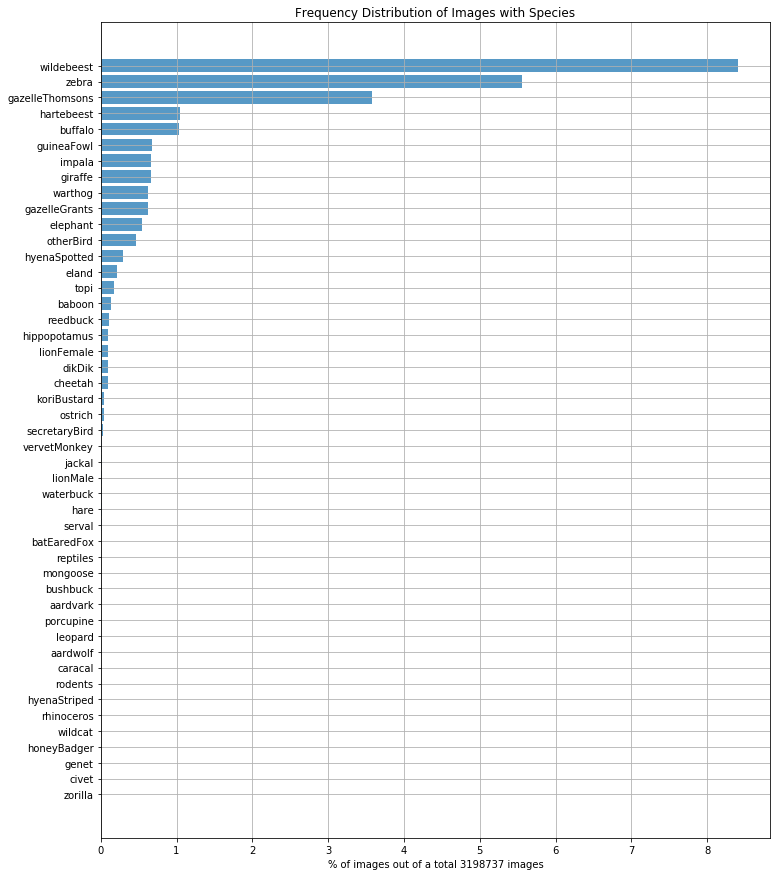

In [45]:
plt.figure(figsize=(12,15))
plt.grid(True)
plt.barh(df_image_species_freq['name'], df_image_species_freq['freq_p'], align='center', alpha=0.75)
plt.title('Frequency Distribution of Images with Species')
plt.xlabel('% of images out of a total {0} images'.format(df_images.shape[0]))

### Create Label_map dictionary

In [12]:
# Uncomment in the below code when creating the label map for the first time

# # the mapping in the label map has to start from 1
# dict1['categories'].pop(0)

# label_map= {}
# label_num = 0
# for lst_element in dict1['categories']:
#     if lst_element['name'] not in label_map:
#         label_map[lst_element['name']] = lst_element['id']
        
# # Creating a json dump for a backup
# with open('../data/LILA/label_map.json', 'w') as outfile:
#     json.dump(label_map, outfile)

# Loading the json dump  
with open('../data/LILA/label_map.json', 'r') as f:
     label_map = json.load(f)
        
# Writing the label map to the pbtxt file
# s = [(k, label_map[k]) for k in sorted(label_map, key=label_map.get, reverse=False)]
# with open('../data/LILA/label_map.pbtxt', 'w') as f:
#     for k, v in s:
#         print("item { \n id:%d \n name:'%s' \n } \n" %(v, k),file=f)

In [13]:
inv_label_map = {v: k for k, v in label_map.items()}
inv_label_map

{1: 'human',
 2: 'gazelleGrants',
 3: 'reedbuck',
 4: 'dikDik',
 5: 'zebra',
 6: 'porcupine',
 7: 'gazelleThomsons',
 8: 'hyenaSpotted',
 9: 'warthog',
 10: 'impala',
 11: 'elephant',
 12: 'giraffe',
 13: 'mongoose',
 14: 'buffalo',
 15: 'hartebeest',
 16: 'guineaFowl',
 17: 'wildebeest',
 18: 'leopard',
 19: 'ostrich',
 20: 'lionFemale',
 21: 'koriBustard',
 22: 'otherBird',
 23: 'batEaredFox',
 24: 'bushbuck',
 25: 'jackal',
 26: 'cheetah',
 27: 'eland',
 28: 'aardwolf',
 29: 'hippopotamus',
 30: 'hyenaStriped',
 31: 'aardvark',
 32: 'hare',
 33: 'baboon',
 34: 'vervetMonkey',
 35: 'waterbuck',
 36: 'secretaryBird',
 37: 'serval',
 38: 'lionMale',
 39: 'topi',
 40: 'honeyBadger',
 41: 'rodents',
 42: 'wildcat',
 43: 'civet',
 44: 'genet',
 45: 'caracal',
 46: 'rhinoceros',
 47: 'reptiles',
 48: 'zorilla'}

### Create TFRecords
Now that the lila json is decoded and visual checks have been done, I will create the TFRecord files

#### TFRecord created on MSI and moved to AWS using sftp file transfer

### Validating the TFRecord by visualizing the image 


In [14]:
def decode_record(serialized_example):
    context_features = {
                        'image/filename': tf.FixedLenFeature([], tf.string),
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/format': tf.FixedLenFeature([], tf.string)
                    }


    context, sequence = tf.parse_single_sequence_example(serialized=serialized_example,
                                              context_features=context_features,
#                                               sequence_features=sequence_features,
                                              example_name=None,
                                              name=None)

    return ({k: v for k, v in context.items()},{k: v for k, v in sequence.items()})

In [15]:
filename_list = ['../data/LILA/ss_all/snapshot_serengeti_s01_s06-0-10000.record']
batch_size = 400
dataset = tf.data.Dataset.from_tensor_slices(filename_list)
dataset = tf.data.TFRecordDataset(dataset)
dataset = dataset.shuffle(buffer_size=batch_size)
dataset = dataset.map(lambda x: decode_record(serialized_example=x)).batch(batch_size)

iterator = dataset.make_one_shot_iterator() # create the iterator
batch_data = iterator.get_next()
        

**Draw images**

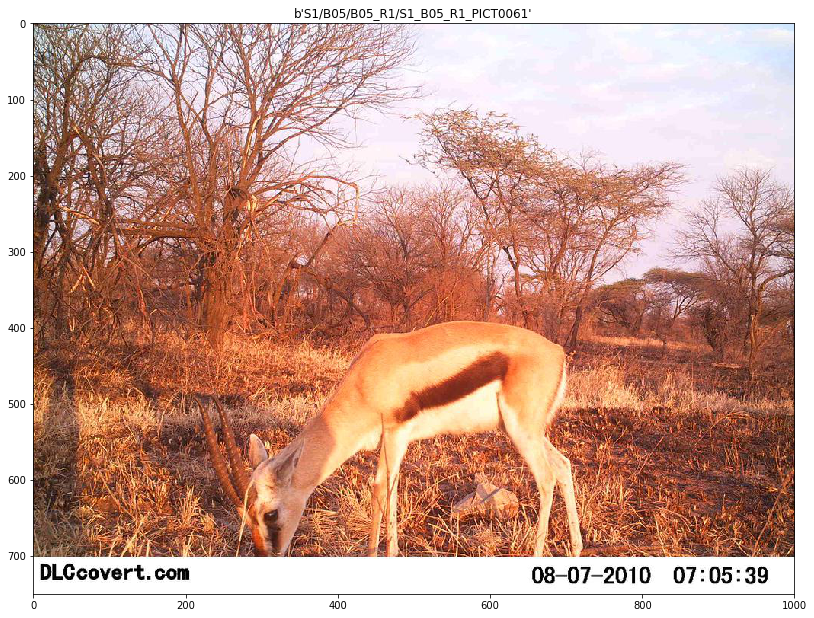

In [32]:
with tf.Session() as sess:
    for i in range(0, 1):
        (context, sequence) = sess.run(batch_data)
        img0 = context['image/encoded'][0]
        filename = context['image/filename'][0]

img = img0
encoded_jpg_io = io.BytesIO(img)
image = Image.open(encoded_jpg_io)
width, height = image.size

i = 0

# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
# Display the image
ax.imshow(image)    
plt.title(filename)
plt.show()

### Predict bounding boxes on the above TFRecord

TF_RECORD_FILES='/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/ss_all/snapshot_serengeti_s01_s06-0-10000.record' <br>

OUTPUT_INFERENCE_GRAPH='/home/ubuntu/data/tensorflow/my_workspace/training_demo/trained-inference-graphs/output_inference_graph/frozen_inference_graph.pb' <br>

python /home/ubuntu/data/tensorflow/models/research/object_detection/inference/infer_detections.py \ <br>
  --input_tfrecord_paths=TF_RECORD_FILES \ <br>
  --output_tfrecord_path='/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/snapshot_serengeti_s01_s06-0-10000.record' \ <br>
  --inference_graph=OUTPUT_INFERENCE_GRAPH \ <br>
  --discard_image_pixels <br>

**Checking the eval TFRecord**

In [33]:
def decode_record(serialized_example):
    context_features = {
                        'image/filename': tf.FixedLenFeature([], tf.string),
                        'image/encoded': tf.FixedLenFeature([], tf.string),
                        'image/format': tf.FixedLenFeature([], tf.string),
                        "image/detection/bbox/xmin" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/xmax" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/ymin" : tf.VarLenFeature(tf.float32),
                        "image/detection/bbox/ymax" : tf.VarLenFeature(tf.float32),
                        "image/detection/label" : tf.VarLenFeature(tf.int64),
                        "image/detection/score" : tf.VarLenFeature(tf.float32)
                    }


    context, sequence = tf.parse_single_sequence_example(serialized=serialized_example,
                                              context_features=context_features,
#                                               sequence_features=sequence_features,
                                              example_name=None,
                                              name=None)

    return ({k: v for k, v in context.items()},{k: v for k, v in sequence.items()})

filename_list = ['/home/ubuntu/data/tensorflow/my_workspace/training_demo/Predictions/snapshot_serengeti_s01_s06-0-10000.record']
# Example for inspecting TFR files
# import matplotlib.pyplot as plt

# dataset = create_tfr_reader(filename_list)

batch_size = 10000
dataset = tf.data.Dataset.from_tensor_slices(filename_list)
dataset = tf.data.TFRecordDataset(dataset)
dataset = dataset.shuffle(buffer_size=batch_size)
dataset = dataset.map(lambda x: decode_record(serialized_example=x)).batch(batch_size)

iterator = dataset.make_one_shot_iterator() # create the iterator
batch_data = iterator.get_next()

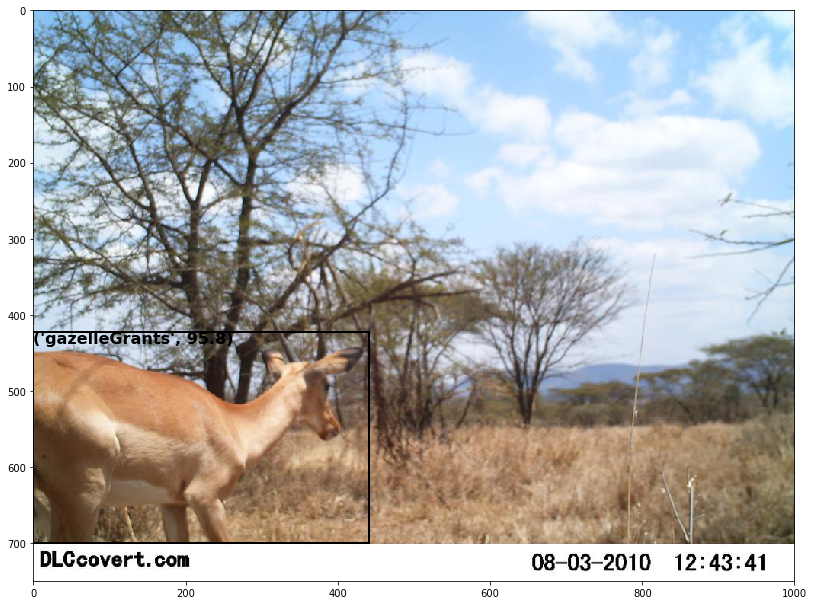

In [43]:
with tf.Session() as sess:
    for i in range(0, 1):
        (context, sequence) = sess.run(batch_data)
        img0 = context['image/encoded'][0]
        # Detection 
        xmin_d = (context['image/detection/bbox/xmin'])
        ymin_d = (context['image/detection/bbox/ymin'])
        xmax_d = (context['image/detection/bbox/xmax'])
        ymax_d = (context['image/detection/bbox/ymax'])
        label_d = (context['image/detection/label'])
        score = (context['image/detection/score'])

score_threshold = 0.5
img = img0
encoded_jpg_io = io.BytesIO(img)
image = Image.open(encoded_jpg_io)
width, height = image.size

i = 0
xmins_d = []
ymins_d = []
xmaxs_d = []
ymaxs_d = []
labels_d = []
scores = []

for j in range(0, xmin_d[0].shape[0]):
    if xmin_d[0][j][0] == i and score[1][j]>=score_threshold:
        xmins_d.append(int(xmin_d[1][j]*width))
        ymins_d.append(int(ymin_d[1][j]*height))
        xmaxs_d.append(int(xmax_d[1][j]*width))
        ymaxs_d.append(int(ymax_d[1][j]*height))
        labels_d.append(label_d[1][j])
        scores.append(round(score[1][j]*100, 1))

# print(labels_d)
# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
# Display the image
ax.imshow(image)
for s in range(len(xmins_d)):
    rect = patches.Rectangle((xmins_d[s],ymins_d[s]),(xmaxs_d[s]-xmins_d[s]), \
                             (ymaxs_d[s] - ymins_d[s]),linewidth=2,edgecolor='black',facecolor='none')
    ax.add_patch(rect)
    
    rx, ry = rect.get_xy()
    cx = rx # + rect.get_width()/2.0
    cy = ry # + rect.get_height()/2.0

    ax.annotate((inv_label_map[labels_d[s]], scores[s]), (cx, cy), color='black', weight='bold', 
                fontsize=16, ha='left', va='top')
    
plt.show()

**Checking the TFRecords for any corrupt category labels**

In [37]:
record_iterator = tf.python_io.tf_record_iterator(path=filename_list[0])
l1 = []
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
  
    l1 = l1 + list(example.features.feature['image/detection/label'].int64_list.value)
    # Exit after 1 iteration as this is purely demonstrative.

print(sorted(list(set(l1))))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
